Transfomer model as a freature extractor

- Extract output of hidden states and use as features for a classification model

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset

In [2]:
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Tokenization

In [3]:
text = 'Tokenization is an important task in NLP'

encoded_text = tokenizer(text)

In [4]:
encoded_text

{'input_ids': [101, 19204, 3989, 2003, 2019, 2590, 4708, 1999, 17953, 2361, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [5]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens

['[CLS]',
 'token',
 '##ization',
 'is',
 'an',
 'important',
 'task',
 'in',
 'nl',
 '##p',
 '[SEP]']

In [6]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenization is an important task in nlp [SEP]'

In [7]:
tokenizer.vocab_size

30522

In [8]:
tokenizer.model_max_length

512

In [9]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

Load emotions dataset

In [10]:
emotions = load_dataset('SetFit/emotion')

Using custom data configuration SetFit--emotion-e444b7640ce3116e
Found cached dataset json (/home/vivek/.cache/huggingface/datasets/SetFit___json/SetFit--emotion-e444b7640ce3116e/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
(emotions)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [14]:
train_ds = emotions['train']

In [16]:
train_ds.column_names

['text', 'label', 'label_text']

In [17]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness'}

In [19]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None),
 'label_text': Value(dtype='string', id=None)}

In [21]:
emotions.set_format(type='pandas')

In [23]:
df = emotions['train'][:]
df.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


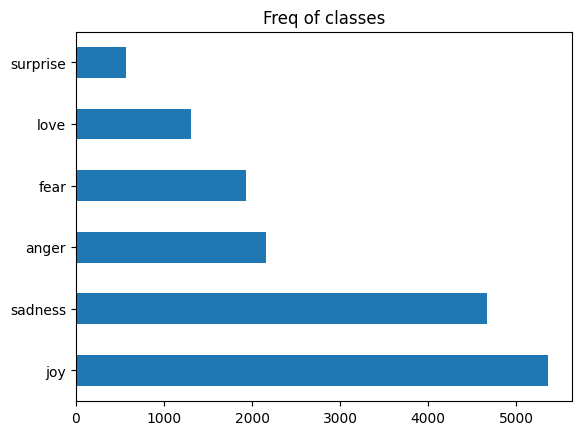

In [28]:
df['label_text'].value_counts().plot.barh()
plt.title('Freq of classes')
plt.show()

Length of tweets

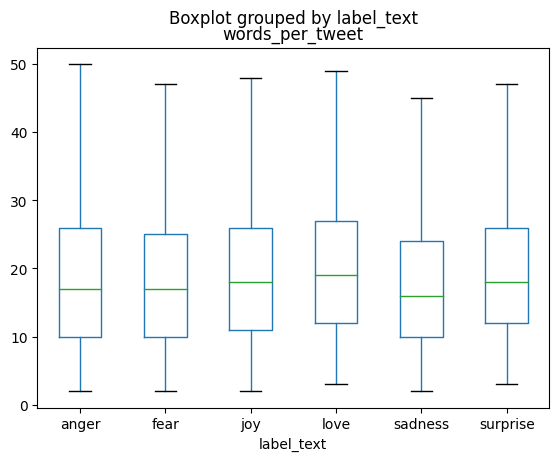

In [31]:
df['words_per_tweet'] = df['text'].str.split().apply(len)
df.boxplot('words_per_tweet', by='label_text', grid=False, showfliers=False)
plt.show()

In [32]:
emotions.reset_format()

Tokenizer function

In [52]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=False)

In [39]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [36]:
tokenizer.convert_tokens_to_ids(tokenizer.all_special_tokens)

[100, 102, 0, 101, 103]

Load pretrained Model

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AutoModel.from_pretrained(model_ckpt).to(device)

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Get the last hidden states

In [43]:
text = 'this is a test'
inputs = tokenizer(text, return_tensors='pt')
print(inputs['input_ids'].size())

torch.Size([1, 6])


In [44]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [45]:
inputs = {k:v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)

print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [46]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

CLS token embeddings are used as the sentence embeddings in BERT

In [47]:
outputs.last_hidden_state[:, 0]b

tensor([[-1.5651e-01, -1.8620e-01,  5.2777e-02, -1.0634e-01, -1.3163e-02,
         -2.6944e-01,  9.2270e-02,  1.5865e-01, -9.8674e-02, -2.9572e-01,
         -1.3788e-01, -3.8061e-02, -5.3617e-02,  1.3045e-01,  3.9713e-02,
          8.6893e-02,  2.5087e-02,  8.6177e-03,  2.5243e-01, -1.3678e-01,
         -1.2137e-01, -1.3896e-01, -1.3426e-01, -9.0844e-02,  3.0509e-02,
         -3.8620e-02,  1.1485e-01, -5.7997e-02,  1.0131e-01,  9.7920e-02,
          3.8740e-03,  1.1950e-01, -6.6339e-02, -2.1257e-02,  1.3090e-01,
          2.6520e-02,  2.3624e-01,  5.0220e-02,  1.3503e-02, -2.1379e-02,
         -8.8323e-02, -9.8360e-02,  2.2675e-01, -2.4940e-02, -1.6261e-01,
         -8.3787e-02, -1.9629e+00, -1.4541e-01, -1.5582e-01, -3.5487e-01,
         -4.5972e-02,  2.0034e-01,  1.3080e-02,  4.9650e-01,  1.0587e-01,
          1.2080e-01, -1.9118e-01,  3.8280e-01,  1.7121e-02, -1.6628e-02,
          2.1525e-01,  4.4381e-02,  3.9334e-03,  3.5416e-02,  1.2238e-01,
          2.1459e-01,  1.5014e-02,  2.

Function to extract last hidden state for a sentence (CLS token embeddings)

In [49]:
def extract_hidden_states(batch):

    inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    return {'hidden_state': last_hidden_state[:, 0].cpu().numpy()}

In [53]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [54]:
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [55]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True) #default batch size of 1000 will be used

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]